Enter the 2x2 interaction matrix J row by row:

Input Interaction Matrix J:
[[1. 2.]
 [2. 3.]]

Eigenvalues:
[-0.23606798  4.23606798]

Eigenvectors:
[[-0.85065081  0.52573111]
 [ 0.52573111  0.85065081]]

Random spin configuration:
[ 1 -1]

--- Encoding Mattis Hamiltonian k = 0 ---
Phase values per macropixel for each spin:
Spin 0: [np.float64(4.158814621487645), np.float64(-1.0172219678978514), np.float64(4.158814621487645), np.float64(-1.0172219678978514)]
Spin 1: [np.float64(-0.553574358897045), np.float64(-2.5880182946927484), np.float64(-0.553574358897045), np.float64(-2.5880182946927484)]


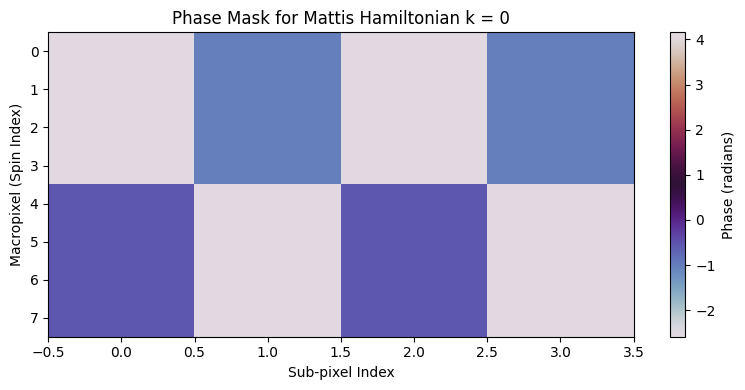


--- Encoding Mattis Hamiltonian k = 1 ---
Phase values per macropixel for each spin:
Spin 0: [np.float64(2.5880182946927484), np.float64(0.553574358897045), np.float64(2.5880182946927484), np.float64(0.553574358897045)]
Spin 1: [np.float64(-1.0172219678978514), np.float64(-2.1243706856919418), np.float64(-1.0172219678978514), np.float64(-2.1243706856919418)]


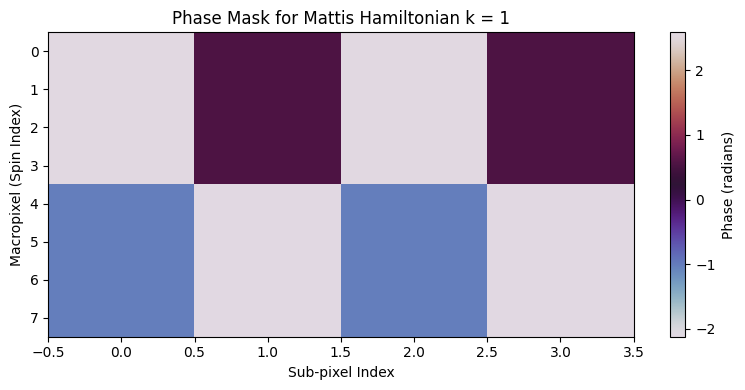

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
PI = np.pi

# Define macro pixel size (can be changed as needed)
MACRO_PIX_X = 4
MACRO_PIX_Y = 4

# Step 1: Get number of spins
n_spins = int(input("Enter number of spins: "))

# Step 2: Get interaction matrix J
print(f"Enter the {n_spins}x{n_spins} interaction matrix J row by row:")
J = []
for i in range(n_spins):
    row = list(map(float, input(f"Row {i+1}: ").split()))
    assert len(row) == n_spins, "Row length must match number of spins."
    J.append(row)
J = np.array(J)

# Step 3: Print the input interaction matrix
print("\nInput Interaction Matrix J:")
print(J)

# Step 4: Eigen decomposition
eigvals, eigvecs = np.linalg.eigh(J)  # Since J is symmetric
print("\nEigenvalues:")
print(eigvals)
print("\nEigenvectors:")
print(eigvecs)

# Step 5: Random spin configuration
spins = np.random.choice([-1, 1], size=n_spins)
print("\nRandom spin configuration:")
print(spins)

# Step 6: Encoding each Mattis Hamiltonian
for k in range(n_spins):
    print(f"\n--- Encoding Mattis Hamiltonian k = {k} ---")
    xi_k = eigvecs[:, k]   # k-th eigenvector
    lambda_k = eigvals[k]  # k-th eigenvalue

    # Gauge transformation: calculate alpha_ik = arccos(xi_ik)
    alpha_ik = np.arccos(np.clip(xi_k, -1.0, 1.0))  # Clip for numerical stability

    # Phase values per macropixel
    phase_mask = np.zeros((n_spins * MACRO_PIX_Y, MACRO_PIX_X))
    for i in range(n_spins):
        for l in range(MACRO_PIX_X):
            phase_value = spins[i] * (PI / 2) + ((-1) ** l) * alpha_ik[i]
            phase_mask[i * MACRO_PIX_Y:(i + 1) * MACRO_PIX_Y, l] = phase_value

    # Print phase values for each spin
    print("Phase values per macropixel for each spin:")
    for i in range(n_spins):
        phases = []
        for l in range(MACRO_PIX_X):
            phase = spins[i] * (PI / 2) + ((-1) ** l) * alpha_ik[i]
            phases.append(phase)
        print(f"Spin {i}: {phases}")

    # Plot the phase mask
    plt.figure(figsize=(8, 4))
    plt.imshow(phase_mask, cmap='twilight', aspect='auto')
    plt.colorbar(label='Phase (radians)')
    plt.title(f'Phase Mask for Mattis Hamiltonian k = {k}')
    plt.xlabel('Sub-pixel Index')
    plt.ylabel('Macropixel (Spin Index)')
    plt.tight_layout()
    plt.show()

